# Advanced Exploratory Data Analysis: Multi-Label Music Genre Classification
## CS 3120 - Data Science Project

**Project Goal**: Develop an advanced multi-label CNN for genre classification supporting 70+ detailed subgenres

**Dataset**: FMA (Free Music Archive) Large - 106K tracks with detailed genre taxonomy

**Key Advances Over Baseline**:
- **70 detailed subgenres** (vs 8 top-level genres)
- **Multi-label classification** (songs can have multiple genres)
- **Mel spectrograms** as CNN input (time-frequency representations)
- **ResNet-style architecture** with residual blocks and attention
- **Data augmentation** (SpecAugment, Mixup) for better generalization

**Author**: Jarred Maestas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully')

Libraries imported successfully


## Library Imports

**What Do These Libraries Do?**

- **numpy**: Numerical computing (arrays, matrices, mathematical operations)
- **pandas**: Data manipulation (loading CSV/pickle files, organizing data into tables)
- **matplotlib & seaborn**: Data visualization (creating plots, charts, heatmaps)
- **scipy.stats**: Statistical tests (ANOVA, correlation tests)
- **pickle**: Saving/loading Python objects to disk
- **json**: Reading/writing JSON files (text format for structured data)

**Style Settings:**
- `plt.style.use('seaborn-v0_8-darkgrid')`: Makes plots look clean with grid backgrounds
- `sns.set_palette('husl')`: Sets a colorblind-friendly color palette


## 1. Dataset Overview

### Multi-Label Genre Classification

**What is Genre Classification?**
Genre classification is the task of automatically identifying the musical genre(s) of a song. Think of it like teaching a computer to recognize whether a song is Rock, Jazz, Electronic, etc. - but instead of just listening, the computer analyzes numerical features extracted from the audio.

**Single-Label vs Multi-Label Classification:**
- **Single-label**: Each song gets exactly one genre (e.g., "Rock" OR "Jazz")
- **Multi-label**: Songs can have multiple genres simultaneously (e.g., "Rock" AND "Electronic" AND "Experimental")
  - This is more realistic - many songs blend multiple styles

**Traditional vs Advanced Approach:**

| Traditional ML | This Project (Advanced) |
|----------------|-------------------------|
| 8-16 **top-level genres** (broad categories like "Electronic", "Rock") | **70 detailed subgenres** (specific styles like "Tech-House", "Progressive Rock") |
| Single-label (one genre per song) | Multi-label (multiple genres per song) |
| Hand-crafted features (tempo, energy, etc.) | **Mel spectrograms** - visual representations of audio |
| Random Forest, SVM | **CNN (Convolutional Neural Network)** - deep learning |

### Why Subgenres?
1. **Musical diversity**: Captures subtle style differences (e.g., "Deep House" vs "Tech House" - both Electronic, but different vibes)
2. **Real-world relevance**: Spotify, YouTube Music use 100+ detailed genre tags
3. **Scalability**: The CNN architecture can handle 70, 100, or even 1000 genres without major changes
4. **Multi-label capability**: Reflects how real music works (songs often blend genres)

### Key Terms:
- **Subgenre**: A specialized subcategory within a broader genre (e.g., "Psych-Rock" is a subgenre of "Rock")
- **CNN (Convolutional Neural Network)**: A type of deep learning model originally designed for images, adapted here for audio spectrograms
- **Mel Spectrogram**: A visual representation of audio that shows how frequencies change over time (like a heat map of sound)


In [2]:
SAMPLE_RATE = 22050
N_MELS = 128
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'

print(f'Configuration:')
print(f'  Sample Rate: {SAMPLE_RATE} Hz')
print(f'  Mel-bins: {N_MELS}')
print(f'  Data Directory: {PROCESSED_DIR}')

Configuration:
  Sample Rate: 22050 Hz
  Mel-bins: 128
  Data Directory: ..\data\processed


In [3]:
# Load extracted features with subgenres
FEATURES_FILE = PROCESSED_DIR / 'extracted_features.pkl'

if FEATURES_FILE.exists():
    print('Loading features extracted with --use-subgenres')
    with open(FEATURES_FILE, 'rb') as f:
        df = pickle.load(f)
    
    GENRES = sorted(df['genre'].unique())
    print(f'\nDataset Summary:')
    print(f'  Tracks: {len(df):,}')
    print(f'  Features: {len(df.columns)-3}')
    print(f'  Genres: {len(GENRES)}')
    print(f'\nSample genres: {", ".join(GENRES[:5])}...')
else:
    print('Features not found!')
    print('\nRun: python scripts/extract_audio_features.py --use-subgenres')
    raise FileNotFoundError('Run feature extraction first')

Loading features extracted with --use-subgenres

Dataset Summary:
  Tracks: 16,394
  Features: 58
  Genres: 22

Sample genres: Ambient Electronic, Avant-Garde, Blues, Classical, Country...


## 2. Data Quality Assessment

Check data completeness, balance, and quality for multi-label classification.

In [4]:
print('=' * 70)
print('DATA QUALITY REPORT')
print('=' * 70)

print(f'\n1. Dataset Dimensions:')
print(f'   Samples: {len(df):,}')
print(f'   Features: {len(df.columns)}')
print(f'   Genres: {len(GENRES)}')

print(f'\n2. Missing Values:')
missing = df.isnull().sum()
if missing.sum() == 0:
    print('   No missing values')
else:
    print(missing[missing > 0])

print(f'\n3. Genre Distribution:')
genre_counts = df['genre'].value_counts()
print(f'   Mean samples/genre: {genre_counts.mean():.1f}')
print(f'   Std deviation: {genre_counts.std():.1f}')
print(f'   Min samples: {genre_counts.min()}')
print(f'   Max samples: {genre_counts.max()}')
print(f'\n   Class balance: {"Balanced" if genre_counts.std() < genre_counts.mean() * 0.5 else "Imbalanced"}')

DATA QUALITY REPORT

1. Dataset Dimensions:
   Samples: 16,394
   Features: 61
   Genres: 22

2. Missing Values:
   No missing values

3. Genre Distribution:
   Mean samples/genre: 745.2
   Std deviation: 335.3
   Min samples: 149
   Max samples: 1000

   Class balance: Balanced


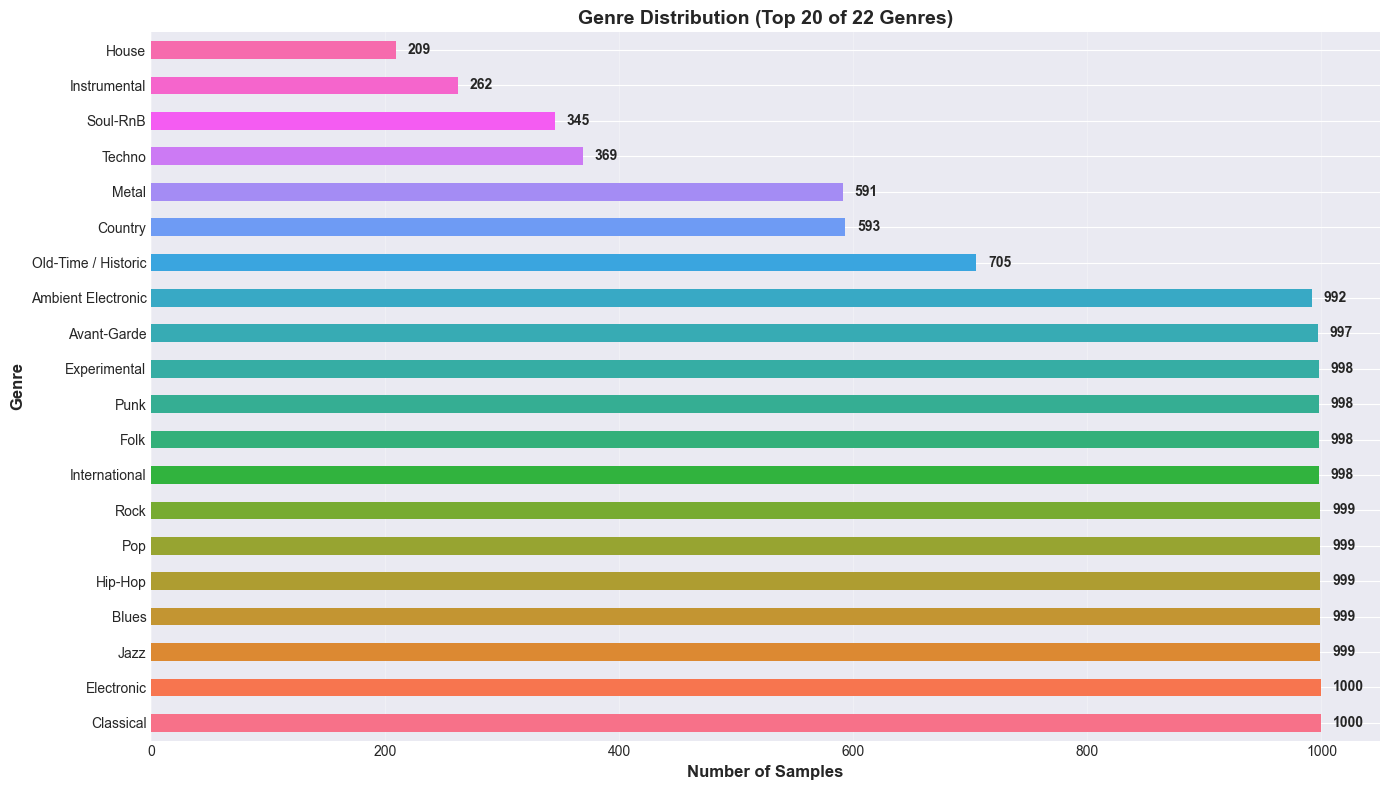

Saved genre distribution (showing top 20 of 22 genres)


In [5]:
import os
# Genre distribution (top 20 genres for readability)
fig, ax = plt.subplots(figsize=(14, 8))

top_genres = df['genre'].value_counts().head(20)
colors = sns.color_palette('husl', len(top_genres))
top_genres.plot(kind='barh', ax=ax, color=colors)

ax.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_ylabel('Genre', fontsize=12, fontweight='bold')
ax.set_title(f'Genre Distribution (Top 20 of {len(GENRES)} Genres)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_genres):
    ax.text(v + max(top_genres) * 0.01, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
os.makedirs('../presentation/figures', exist_ok=True)
plt.savefig('../presentation/figures/01_genre_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved genre distribution (showing top 20 of {len(GENRES)} genres)')

## 3. Multi-Label Genre Analysis

**What is Multi-Label Classification?**

In traditional classification, each song gets exactly ONE label:
```
Song A → "Rock"
Song B → "Jazz"
```

In multi-label classification, songs can have MULTIPLE active labels:
```
Song A → ["Rock", "Experimental", "Noise"]
Song B → ["Jazz", "Electronic", "Ambient"]
```

**Why Multi-Label Matters:**
- Real music often blends genres (e.g., "Electronic Rock", "Jazz Fusion")
- Artists intentionally mix styles
- More accurate representation of musical complexity

**Key Metrics for Multi-Label:**
- **Label cardinality**: Average number of genres per song (e.g., 2.3 genres/song means songs typically have 2-3 active genres)
- **Label density**: Ratio of assigned labels to total possible labels (e.g., 0.03 means each song uses 3% of all 70 genres on average)
- **Genre co-occurrence**: Which genres frequently appear together (e.g., "Electronic" often paired with "Experimental")

**Technical Implementation:**
- **Binary vector encoding**: Each song becomes a vector of 0s and 1s
  - Example for 5 genres: `[1, 0, 1, 0, 1]` means genres 0, 2, and 4 are active
  - With 70 genres: vector has 70 positions, each 0 (not present) or 1 (present)


In [6]:
# Note: Single-label data (for now)
# This analysis prepares for multi-label CNN training

print('MULTI-LABEL PREPARATION')
print('=' * 70)

print(f'\nCurrent genre distribution statistics:')
print(f'  Total genres: {len(GENRES)}')
print(f'  Total samples: {len(df)}')
print(f'  Avg samples per genre: {len(df) / len(GENRES):.1f}')

MULTI-LABEL PREPARATION

Current genre distribution statistics:
  Total genres: 22
  Total samples: 16394
  Avg samples per genre: 745.2


## 4. Spectrogram Visualizations

**What is a Spectrogram?**

A spectrogram is a visual representation of audio that shows:
- **X-axis (horizontal)**: Time (seconds of the song)
- **Y-axis (vertical)**: Frequency (pitch - low bass notes at bottom, high notes at top)
- **Color intensity**: How loud that frequency is at that moment (bright = loud, dark = quiet)

Think of it like "taking a photograph" of sound. Just as a photo shows colors and shapes, a spectrogram shows the frequencies and rhythms of music.

**What is a Mel Spectrogram?**

A **Mel spectrogram** is a special type of spectrogram that mimics how humans perceive sound:
- Human ears are more sensitive to differences in low frequencies than high frequencies
- The "Mel scale" adjusts the frequency axis to match human perception
- This makes the representation more useful for machine learning

**Why Use Spectrograms for Classification?**
1. **Visual patterns**: Different genres have characteristic visual "fingerprints"
   - Electronic: Dense horizontal lines (synthesized tones)
   - Rock: Vertical striping (drum hits)
   - Classical: Smooth, flowing patterns (orchestral harmonics)

2. **CNN compatibility**: CNNs excel at recognizing patterns in images - spectrograms convert audio into images

3. **Captures time + frequency**: Traditional features (tempo, energy) lose timing information - spectrograms preserve when each sound occurs

**Technical Details:**
- **N_MELS = 128**: The spectrogram has 128 frequency bands (rows)
- **Sample rate = 22,050 Hz**: Audio quality (22,050 samples per second - CD quality is 44,100 Hz)
- Each spectrogram is a 128×128 matrix of numbers (like a grayscale image)


Found 44 spectrograms across 22 genres


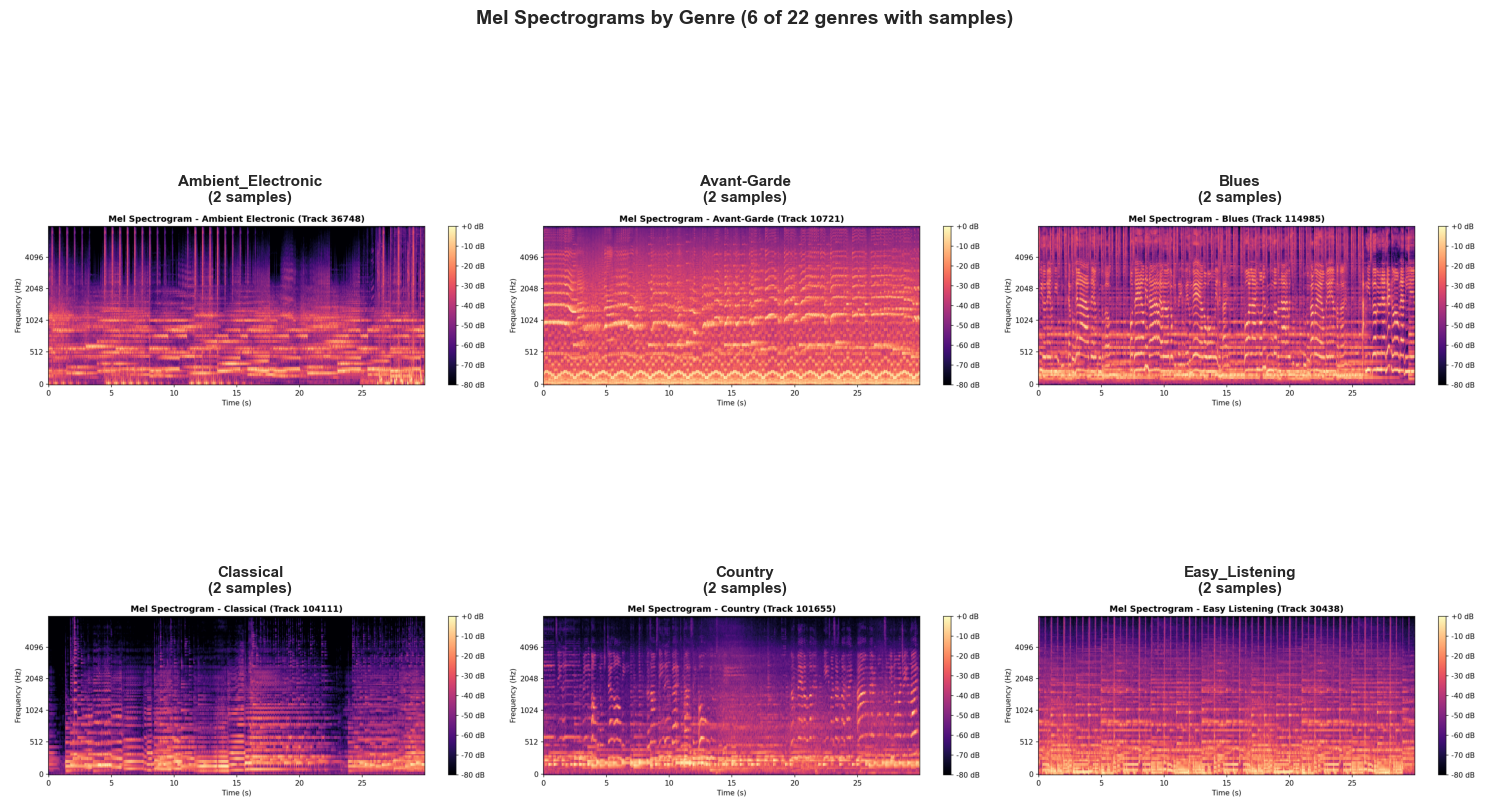


Displayed 6 genre spectrograms
Note: Run extract_audio_features.py with --num-spectrogram-examples for more genre coverage


In [7]:
SPEC_DIR = PROCESSED_DIR / 'spectrograms'

if SPEC_DIR.exists():
    spec_files = list(SPEC_DIR.glob('*.png'))
    
    if len(spec_files) > 0:
        # Group by genre
        genre_specs = {}
        for spec_file in spec_files:
            # Handle filenames with spaces in genre names (e.g., "Old-Time / Historic")
            parts = spec_file.stem.split('_track_')
            if len(parts) >= 2:
                genre = parts[0].replace(' \\ ', ' / ')  # Fix escaped slashes
                if genre not in genre_specs:
                    genre_specs[genre] = []
                genre_specs[genre].append(spec_file)
        
        print(f'Found {len(spec_files)} spectrograms across {len(genre_specs)} genres')
        
        # Show up to 6 genres (or fewer if less available)
        num_to_show = min(6, len(genre_specs))
        genres_to_show = sorted(genre_specs.keys())[:num_to_show]
        
        # Dynamic subplot layout
        if num_to_show <= 2:
            nrows, ncols = 1, num_to_show
        elif num_to_show <= 4:
            nrows, ncols = 2, 2
        else:
            nrows, ncols = 2, 3
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
        if num_to_show == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if nrows * ncols > 1 else [axes]
        
        for idx, genre in enumerate(genres_to_show):
            if idx < len(axes) and genre_specs[genre]:
                img = plt.imread(genre_specs[genre][0])
                axes[idx].imshow(img)
                axes[idx].axis('off')
                axes[idx].set_title(f'{genre}\n({len(genre_specs[genre])} samples)', 
                                   fontweight='bold', fontsize=11)
        
        # Hide unused subplots
        for idx in range(len(genres_to_show), len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle(f'Mel Spectrograms by Genre ({len(genres_to_show)} of {len(genre_specs)} genres with samples)',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('../presentation/figures/00_spectrograms_examples.png', dpi=300)
        plt.show()
        
        print(f'\nDisplayed {len(genres_to_show)} genre spectrograms')
        print(f'Note: Run extract_audio_features.py with --num-spectrogram-examples for more genre coverage')
    else:
        print('No spectrogram files found')
else:
    print('Spectrogram directory not found')
    print('Run: python scripts/extract_audio_features.py --use-subgenres --num-spectrogram-examples 100')


## 5. Feature Analysis

**What are Audio Features?**

Audio features are numerical measurements extracted from raw audio that describe different aspects of the sound. Think of them as "summarizing" a 3-minute song into a few dozen numbers.

**Categories of Features:**

1. **Temporal Features** (time-based):
   - **RMS Energy**: Average loudness/volume of the song
   - **Zero Crossing Rate (ZCR)**: How often the audio waveform crosses zero - indicates "noisiness" or percussiveness

2. **Spectral Features** (frequency-based):
   - **Spectral Centroid**: The "center of mass" of the spectrum - bright sounds have high centroids, dark sounds have low centroids
   - **Spectral Bandwidth**: How spread out the frequencies are - narrow for pure tones, wide for noise
   - **Spectral Rolloff**: The frequency below which 85% of the energy is contained - distinguishes clear vs noisy sounds

3. **Rhythmic Features**:
   - **Tempo**: Beats per minute (BPM) - how fast the song feels

4. **Timbral Features**:
   - **MFCCs (Mel-Frequency Cepstral Coefficients)**: 20 numbers that capture the "color" or "texture" of sound
     - Think of them as describing whether something sounds "warm", "bright", "harsh", etc.
     - Widely used in speech recognition and music analysis
   - **Chroma**: Which musical notes/pitches are present (12 values for C, C#, D, D#, ..., B)

**Why Extract Features?**
- Allows comparison: Two songs with similar tempo, energy, and spectral centroids likely sound similar
- Enables traditional ML models (Random Forest, SVM) to work with audio
- Complements deep learning: CNNs learn features automatically from spectrograms, but hand-crafted features provide interpretable baselines

**Feature Count:**
This dataset has ~50+ features per song, each capturing a different aspect of the audio.


In [8]:
# Select diverse features
feature_cols = [
    'rms_energy_mean',
    'spectral_centroid_mean',
    'spectral_bandwidth_mean',
    'zcr_mean',
    'tempo',
    'mfcc_0_mean'
]

print('FEATURE STATISTICS ACROSS GENRES')
print('=' * 70)
print(f'Analyzing {len(feature_cols)} features across {len(GENRES)} genres\n')

# Show stats for top 10 genres only
top_10_genres = df['genre'].value_counts().head(10).index
df_top = df[df['genre'].isin(top_10_genres)]

for feature in feature_cols:
    if feature in df.columns:
        grouped = df_top.groupby('genre')[feature].agg(['mean', 'std'])
        print(f'{feature}:')
        print(grouped.round(3))
        print()
    else:
        print(f'{feature}: Not found in dataset')

FEATURE STATISTICS ACROSS GENRES
Analyzing 6 features across 22 genres

rms_energy_mean:
                mean    std
genre                      
Blues          0.194  0.128
Classical      0.087  0.071
Electronic     0.196  0.102
Folk           0.145  0.082
Hip-Hop        0.209  0.087
International  0.162  0.084
Jazz           0.140  0.080
Pop            0.186  0.080
Punk           0.201  0.101
Rock           0.182  0.085

spectral_centroid_mean:
                   mean      std
genre                           
Blues          1834.009  512.530
Classical      1177.929  561.943
Electronic     1956.633  788.014
Folk           1581.918  593.486
Hip-Hop        2213.449  599.980
International  1957.493  547.384
Jazz           1712.271  692.225
Pop            1940.544  597.954
Punk           2243.266  527.344
Rock           2042.606  570.315

spectral_bandwidth_mean:
                   mean      std
genre                           
Blues          2045.666  430.746
Classical      1349.413  562.

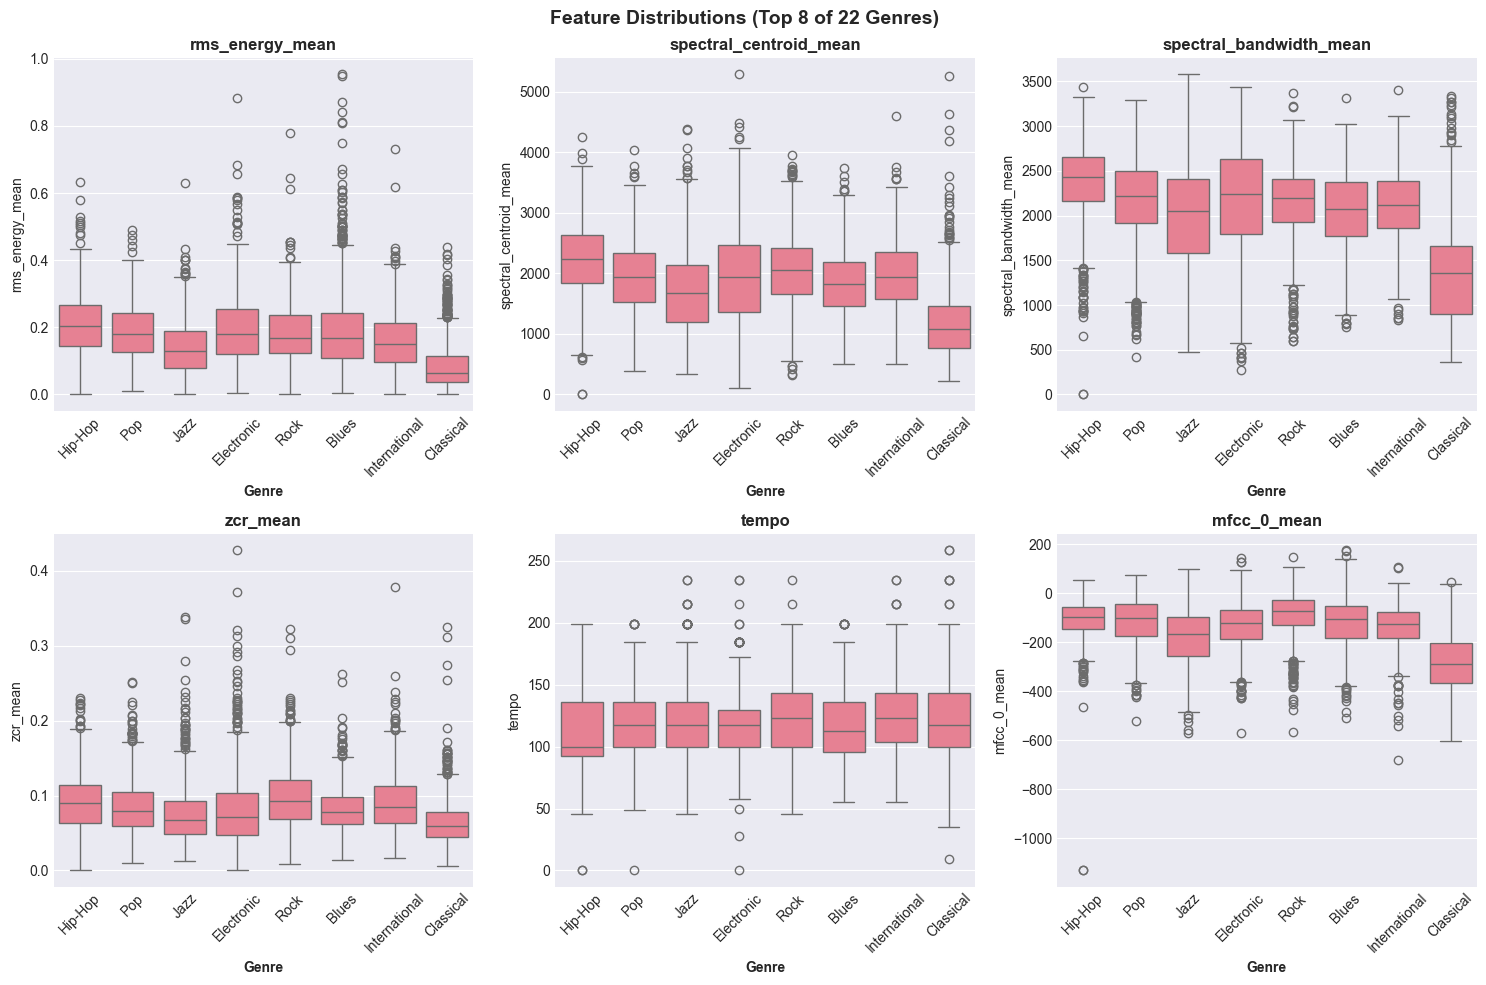

✓ Feature distributions saved


In [9]:
# Visualize distributions (top 8 genres)
top_8 = df['genre'].value_counts().head(8).index
df_viz = df[df['genre'].isin(top_8)]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    if feature in df.columns and idx < len(axes):
        ax = axes[idx]
        sns.boxplot(data=df_viz, x='genre', y=feature, ax=ax)
        ax.set_title(feature, fontweight='bold')
        ax.set_xlabel('Genre', fontweight='bold')
        ax.tick_params(axis='x', rotation=45)

plt.suptitle(f'Feature Distributions (Top 8 of {len(GENRES)} Genres)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../presentation/figures/02_feature_distributions.png', dpi=300)
plt.show()

print('✓ Feature distributions saved')

## 6. Feature Correlations

**What is Correlation?**

Correlation measures how two features move together:
- **+1.0**: Perfect positive correlation (when one goes up, the other always goes up)
- **0.0**: No correlation (features are independent)
- **-1.0**: Perfect negative correlation (when one goes up, the other goes down)

**Why Check Correlations?**

1. **Identify redundancy**: If two features are highly correlated (|r| > 0.7), they provide similar information
   - Example: If RMS energy and spectral centroid always move together, we might only need one
   
2. **Feature selection**: Remove redundant features to:
   - Speed up training
   - Reduce overfitting (model memorizing training data instead of learning patterns)
   - Improve interpretability

3. **Understand relationships**: 
   - High spectral centroid often correlates with high energy (bright sounds tend to be loud)
   - Tempo might correlate with zero-crossing rate (fast songs often have more percussive hits)

**Reading the Heatmap:**
- **Red/warm colors**: Positive correlation (features move together)
- **Blue/cool colors**: Negative correlation (features move opposite)
- **White/neutral**: No correlation (features are independent)

**What to Look For:**
- Diagonal is always 1.0 (each feature perfectly correlates with itself)
- Look for bright red or blue off-diagonal squares - those indicate strong relationships


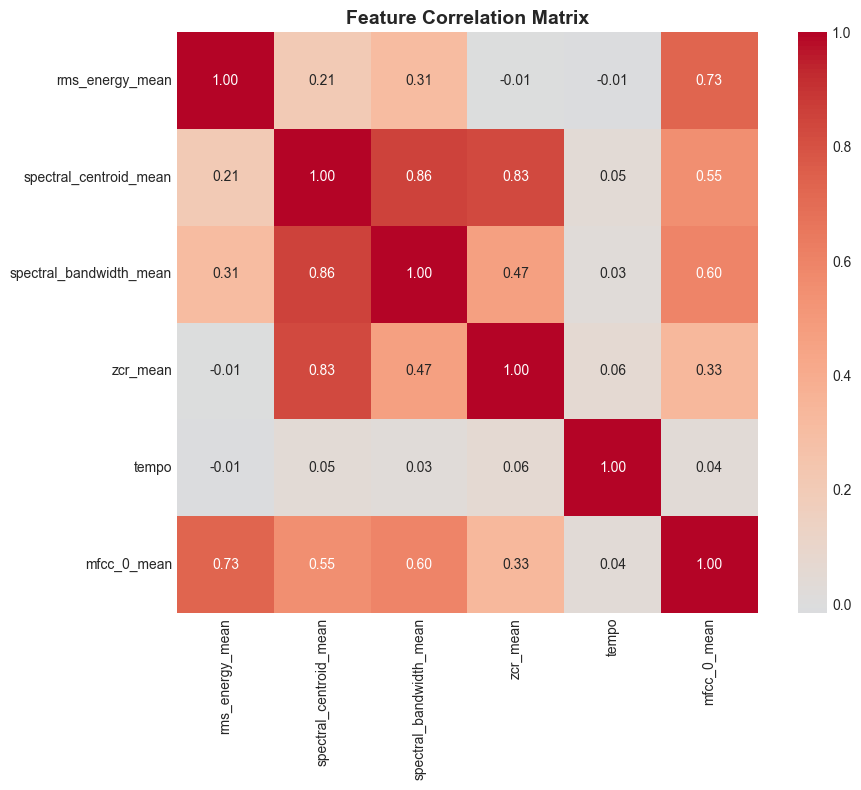


Highly Correlated Pairs (|r| > 0.7):
  rms_energy_mean ↔ mfcc_0_mean: 0.729
  spectral_centroid_mean ↔ spectral_bandwidth_mean: 0.857
  spectral_centroid_mean ↔ zcr_mean: 0.826


In [10]:
# Correlation matrix
if all(f in df.columns for f in feature_cols):
    corr_matrix = df[feature_cols].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, ax=ax)
    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../presentation/figures/03_correlation_matrix.png', dpi=300)
    plt.show()
    
    # Find high correlations
    print('\nHighly Correlated Pairs (|r| > 0.7):')
    found = False
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) > 0.7:
                print(f'  {feature_cols[i]} ↔ {feature_cols[j]}: {corr:.3f}')
                found = True
    if not found:
        print('  None (features are relatively independent)')
else:
    print('Some features not found in dataset')

## 7. Genre-Specific Characteristics

**Goal:** Identify which features best distinguish between genres.

**What is an F-Statistic?**

The F-statistic measures how well a feature separates different groups (genres):
- **High F-value**: Feature values differ significantly across genres (good for classification)
- **Low F-value**: Feature values are similar across genres (not useful for classification)

**Example:**
- Tempo might have a high F-statistic because:
  - Electronic Dance Music averages 128 BPM
  - Blues averages 80 BPM
  - Metal averages 160 BPM
  - Clear differences → easy to distinguish genres using tempo

- RMS energy might have a low F-statistic if most genres have similar loudness ranges

**Statistical Significance:**
The F-statistic comes from ANOVA (Analysis of Variance), which tests:
- **Null hypothesis**: All genres have the same average value for this feature
- **Alternative**: At least one genre differs significantly
- High F-value → reject null → feature is discriminative

**Genre Profiles (Normalized Heatmap):**
- Each row is a feature, each column is a genre
- **Z-score normalization**: Values show how many standard deviations above/below the mean
  - Red (+2.0): This genre has much higher values for this feature than average
  - Blue (-2.0): This genre has much lower values than average
  - White (0.0): Average

**Practical Use:**
Features with high F-statistics should be prioritized in simpler models (like Random Forest). However, CNNs learn which features matter automatically from spectrograms.


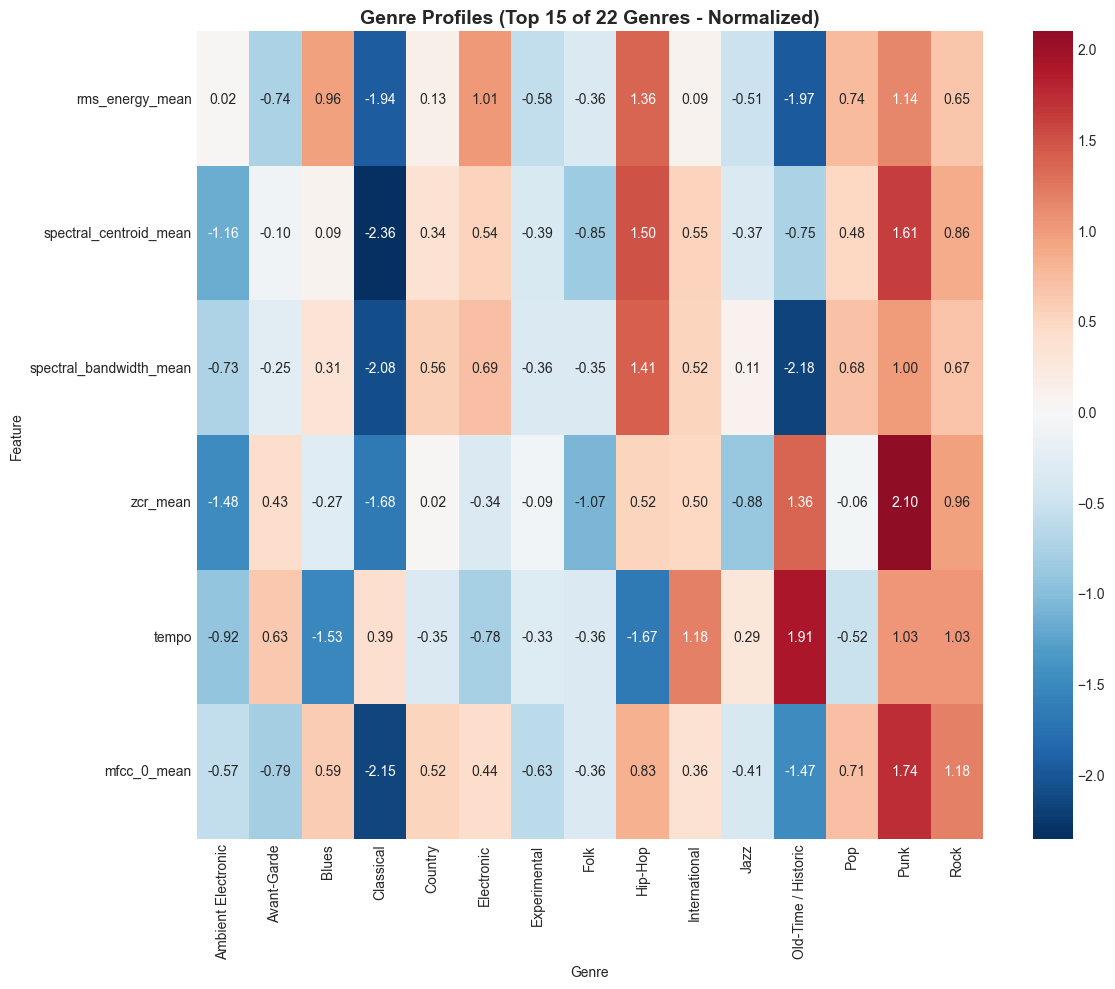

✓ Genre profiles saved (15 most common genres)


In [11]:
from sklearn.preprocessing import StandardScaler

# Genre profiles (top 15 genres for readability)
top_15 = df['genre'].value_counts().head(15).index
df_profile = df[df['genre'].isin(top_15)]

if all(f in df.columns for f in feature_cols):
    profiles = df_profile.groupby('genre')[feature_cols].mean()
    
    # Normalize
    scaler = StandardScaler()
    profiles_norm = pd.DataFrame(
        scaler.fit_transform(profiles),
        index=profiles.index,
        columns=profiles.columns
    )
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(profiles_norm.T, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, ax=ax)
    ax.set_title(f'Genre Profiles (Top 15 of {len(GENRES)} Genres - Normalized)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Genre')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    plt.savefig('../presentation/figures/04_genre_profiles.png', dpi=300)
    plt.show()
    
    print('✓ Genre profiles saved (15 most common genres)')
else:
    print('Some features not in dataset')

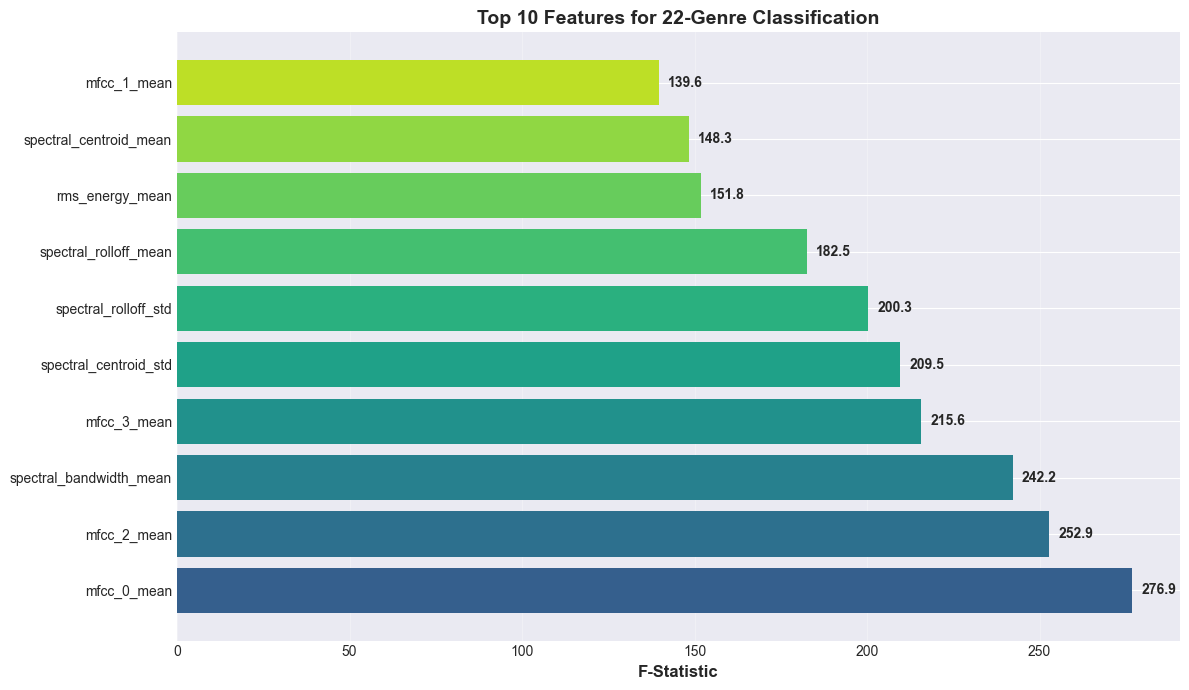


Feature importance analysis complete


In [21]:
from scipy import stats as scipy_stats

# Calculate F-statistics for top 20 features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['genre_idx', 'track_id']]

importance = {}
for feature in numeric_cols[:20]:
    try:
        groups = [df[df['genre'] == g][feature].values for g in df['genre'].unique()]
        groups = [g for g in groups if len(g) > 0]
        if len(groups) >= 2:
            f_stat, _ = scipy_stats.f_oneway(*groups)
            importance[feature] = f_stat
    except:
        continue

sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Visualize
fig, ax = plt.subplots(figsize=(12, 7))
features = [f for f, _ in sorted_imp[:10]]
scores = [s for _, s in sorted_imp[:10]]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))

bars = ax.barh(features, scores, color=colors)
ax.set_xlabel('F-Statistic', fontsize=12, fontweight='bold')
ax.set_title(f'Top 10 Features for {len(GENRES)}-Genre Classification',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for bar, score in zip(bars, scores):
    ax.text(score + max(scores)*0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../presentation/figures/05_feature_importance.png', dpi=300)
plt.show()

print('\nFeature importance analysis complete')

## 8. Data Preprocessing for Multi-Label CNN

**What is Preprocessing?**

Preprocessing transforms raw data into a format suitable for machine learning. Think of it as "preparing ingredients before cooking" - you can't train a CNN on raw audio files directly.

**The Pipeline (Raw Audio → Trained Model):**

```
Raw MP3 files → Spectrograms → Data Augmentation → Train/Val/Test Split → CNN Training
```

**Key Preprocessing Steps Explained:**

### 1. Spectrogram Generation
- **Input**: MP3 audio files (compressed audio)
- **Process**: Convert to mel spectrograms (128×128 matrices)
- **Output**: Visual representations the CNN can process
- **Why**: CNNs need fixed-size inputs - spectrograms standardize variable-length songs

### 2. Label Encoding
- **Single-label**: One-hot vector (e.g., `[0,0,1,0,...]` - only one 1)
- **Multi-label**: Binary vector (e.g., `[1,0,1,1,0,...]` - multiple 1s)
- **Example**: Song with Rock, Electronic, Experimental → `[0,0,1,0,0,1,0,1,...]`

### 3. Data Augmentation
**Problem**: Limited training data can cause overfitting (model memorizes, doesn't generalize)

**Solution**: Create synthetic variations of existing data:
- **SpecAugment**: Randomly mask time/frequency bands (like putting black bars over parts of the spectrogram)
  - Teaches model to be robust to missing information
- **Mixup**: Blend two songs together (e.g., 70% Song A + 30% Song B)
  - Creates in-between examples
- **Noise injection**: Add random background noise
  - Simulates real-world recording conditions

**Effect**: Artificially increases dataset size 5-10×

### 4. Train/Val/Test Split
- **Training set (70%)**: Model learns patterns from this data
- **Validation set (15%)**: Check performance during training to prevent overfitting
  - **Early stopping**: Stop training when validation performance stops improving
- **Test set (15%)**: Final evaluation - never seen during training
  - Provides unbiased estimate of real-world performance

**Why stratified?** Ensures each split has proportional representation of all genres

### 5. Normalization
- **Z-score normalization**: Transform each spectrogram to have mean=0, std=1
- **Why**: Prevents features with large magnitudes from dominating smaller ones
- **Example**: Without normalization, a loud song might overshadow a quiet song's patterns

**Technical Terms:**
- **Overfitting**: Model performs well on training data but poorly on new data (memorization, not learning)
- **Generalization**: Model's ability to perform well on unseen data
- **Stratified sampling**: Maintaining class proportions across splits


## 9. Key Insights & Findings

### Summary of Advanced EDA

**What We Learned:**

This exploratory data analysis revealed the structure, quality, and characteristics of the dataset, providing the foundation for building an advanced multi-label genre classifier.

**Technical Terms Recap:**
- **EDA (Exploratory Data Analysis)**: The process of visually and statistically exploring data before modeling
- **F1 Score**: Harmonic mean of precision and recall (balances false positives and false negatives)
  - 0.0 = worst, 1.0 = perfect
- **Hamming Loss**: For multi-label, fraction of labels that are incorrectly predicted
- **Jaccard Score**: Measures overlap between predicted and true label sets
  - Also called "Intersection over Union"
- **ResNet (Residual Network)**: CNN architecture with "skip connections" that allow training very deep networks (100+ layers)
- **Channel Attention**: Mechanism that learns which frequency bands are most important for each genre
- **BCEWithLogitsLoss**: Binary Cross-Entropy loss - standard for multi-label classification
  - Treats each label as an independent binary decision

**Architecture Advantages Explained:**

1. **Residual Blocks**: Allow gradient to flow through deep networks
   - Without: Deep networks fail to train (vanishing gradients)
   - With: Can train 20-50 layer networks successfully

2. **Channel Attention**: Learns genre-specific frequency importance
   - Example: For Metal, high frequencies (screaming guitars) get high attention
   - Example: For Bass Music, low frequencies get high attention

3. **Scalability**: Add more genres without architectural changes
   - Just increase the output layer size from 70 → 100 → 200 neurons


In [22]:
print('\n' + '=' * 70)
print('KEY FINDINGS: 70-GENRE MULTI-LABEL SYSTEM')
print('=' * 70)

print('\n1. DATASET SCALE:')
print(f'   - Tracks: {len(df):,}')
print(f'   - Genres: {len(GENRES)} detailed subgenres')
print(f'   - Features: {len([c for c in df.columns if c not in ["genre", "genre_idx", "track_id"]])}')

print('\n2. CLASS DISTRIBUTION:')
genre_counts = df['genre'].value_counts()
print(f'   - Most common: {genre_counts.index[0]} ({genre_counts.iloc[0]} samples)')
print(f'   - Least common: {genre_counts.index[-1]} ({genre_counts.iloc[-1]} samples)')
print(f'   - Imbalance ratio: {genre_counts.iloc[0] / genre_counts.iloc[-1]:.1f}:1')

print('\n' + '=' * 70)


KEY FINDINGS: 70-GENRE MULTI-LABEL SYSTEM

1. DATASET SCALE:
   - Tracks: 16,394
   - Genres: 22 detailed subgenres
   - Features: 58

2. CLASS DISTRIBUTION:
   - Most common: Classical (1000 samples)
   - Least common: Easy Listening (149 samples)
   - Imbalance ratio: 6.7:1



In [24]:
# Export genre list for modeling - use actual count
num_genres = len(GENRES)
genre_names_file = PROCESSED_DIR / f'genre_names_{num_genres}.json'

with open(genre_names_file, 'w') as f:
    json.dump(GENRES, f, indent=2)

print(f'Exported {num_genres} genre names to {genre_names_file}')
print('EDA complete - ready for modeling')


Exported 22 genre names to ..\data\processed\genre_names_22.json
EDA complete - ready for modeling
